# Dependencies

In [1]:
from typing import Optional, TypedDict, Annotated
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph
from pydantic import BaseModel, Field
import json
import csv
import numpy as np
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import START
from IPython.display import Image, display

# Gathering API Keys
Langsmith API, OpenAI API, Tavily API keys set as environment variables.

LANGSMITH_TRACING=true

LANGSMITH_ENDPOINT="https://api.smith.langchain.com"

LANGSMITH_PROJECT="homicide-statistics-agent"

# City Schema

In [2]:
class City(BaseModel):
    """Homicide statistics for a city"""
    city: Optional[str] = Field(default=None, description="The name of the city")
    state: Optional[str] = Field(default=None, description="The full name of the state that the city is in, if the state is in the US")
    country: Optional[str] = Field(default=None, description="The full name of the country that the city is in")
    homicides: Optional[dict[int, int]] = Field(
        default=None, description="A dictionary with years as keys, and the homicide count as values"
    )

city_schema = str(City.model_json_schema())

# Defining Tools for the Agent to Use

### Web Search Tool

In [3]:
# langchain already has this tool, so no need to define it ourselves
@tool
def search_web(query: str) -> str:
    """Search the web given a query"""
    print(f'Searching {query}')
    search = TavilySearchResults(max_results=10, include_raw_content=True)
    search_results = search.invoke(query)
    return str(search_results)

# test of this tool
# web_query_austin = "homicide counts in austin texas 2020-2025"
# web_result_austin = search_web(web_query_austin)
# web_query_boston = "homicide counts in boston 2020-2025"
# web_result_boston = search_web(web_query_boston)
# print(web_result_austin)
# print(web_result_boston)

### Write CSV Tool

In [4]:
@tool
def write_csv(data: str, filename: str, years: list[int]):
    """ Writes the data to a csv file. This function should only be called the first time the Writer acts.
    Data should only be written to a csv until the caller has made multiple attempts to revise and fill in any
    NaN/null/None values in the data.

    Args:
    
    data (str): a string that represents a list of JSON-formatted strings that follow the City schema.
    data must follow the City schema.

    filename (str): the name of the file.

    years (list[int]): the relevant years.
    """
    
    city_json = json.loads(data)
    with open(filename, 'w') as file:
        writer = csv.writer(file)
        writer.writerow(["city", "state", "country"] + [str(year) for year in years])
        for city in city_json:
            row = [city["city"]]
            row.append(city["state"]) if city["state"] else row.append(np.nan)
            row.append(city["country"]) if city["country"] else row.append(np.nan)
            if city["homicides"]:
                row.extend(
                    [
                        str(city["homicides"].get(str(year), np.nan)) for year in years
                    ]
                )
            else:
                row.extend([np.nan] * len(years))
            writer.writerow(row)
    

# test of this tool
# write_csv(df, "test.csv")

### Append CSV Tool

In [5]:
@tool
def append_csv(data: str, years: list[int], filename: str):
    """
    Append data to the csv with filename. This function should be called every time the writer wants to write to a csv, except the first time.
    """
    city = json.loads(data)
    row = [city["city"]]
    row.append(city["state"]) if city["state"] else row.append(np.nan)
    row.append(city["country"]) if city["country"] else row.append(np.nan)
    if city["homicides"]:
        row.append(
            [
                city["homicides"][year] if city["homicides"][year] else np.nan for year in years
            ]
        )
    else:
        row.append([np.nan] * len(years))
    
    with open(filename, 'a') as file:
        writer = csv.writer(file)
        writer.writerow(row)

### A single agent interacts with the tools given

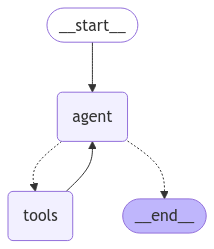

In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

agent_template = f"""
You are an agent tasked with searching the internet for homicide numbers of various cities across some years.
Each time you are requested to find a number of homicides for some cities across a range of years, strictly follow these steps:\n
1. Turn the user's request into one or more search-engine-friendly queries, and use these queries to search the internet.\n
2. Extract relevant information from the search results. If a value is not explicitly stated, do not extract it -- only extract values you are certain of.
If you do not know a value, leave that value as null.\n
3. If there is still missing information, create a refined search-engine-friendly query to search the internet with. Extract relevant information from these results.
If the information is still missing, revise your search-engine-friendly query by using synonyms and similar phrases, while preserving the semantics of the original request.\n
4. Repeat step 3 until there is no missing information. Do not proceed until all values have been found.\n
5. Once all values have been found, write the values to a csv. There should be no null, None, or NaN values in the data that you write to the csv.
The data provided to write_csv must follow a specific schema.
The City schema is as follows:\n {city_schema.replace('{', '{{').replace('}', '}}')}
"""

agent_prompt = ChatPromptTemplate.from_messages([
    ("system", agent_template),
    ("human", "{user_input}")
])

tools = [search_web, write_csv]

llm = ChatOpenAI(model="gpt-4o").bind_tools(tools)
chain = agent_prompt | llm

def agent(state: State):
    return {"messages": chain.invoke(state["messages"])}
graph_builder.add_node("agent", agent)


tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "agent",
    tools_condition,
)
graph_builder.add_edge("tools", "agent") # any time a tool is used, we want to return to the agent
graph_builder.add_edge(START, "agent")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
def see_output(content: str, graph):
    # graph is supposed to be type CompiledStateGraph but for some reason i can't import that
    for s in graph.stream(
        {
            "messages": [
                HumanMessage(content=content)
            ]
        }
    ):
        if "__end__" not in s:
            print(s)
            print("------")

In [8]:
see_output("Determine the annual homicide counts from 2019-2023 (inclusive) for New York City, New Orleans, and Los Angeles, and write them to \"test.csv\".", graph)

{'agent': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_JFd4QgRxfFESKwmF5aWMvS1u', 'function': {'arguments': '{"query": "New York City homicide counts 2019 2020 2021 2022 2023"}', 'name': 'search_web'}, 'type': 'function'}, {'id': 'call_gGrIv6OXsESQ33DV1cJeQpv5', 'function': {'arguments': '{"query": "New Orleans homicide counts 2019 2020 2021 2022 2023"}', 'name': 'search_web'}, 'type': 'function'}, {'id': 'call_nKPOYvClIkUDY5O4GMJq4pJo', 'function': {'arguments': '{"query": "Los Angeles homicide counts 2019 2020 2021 2022 2023"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 114, 'prompt_tokens': 728, 'total_tokens': 842, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprin

The agent is general across years and cities, and can hold a regular conversation:

In [9]:
see_output("Determine the annual homicide counts from 2019-2023 (inclusive) for Boston and London, and write them to \"different_cities.csv\".", graph)

{'agent': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5mYUO1eTIlOKhRqCfLDmoNus', 'function': {'arguments': '{"query": "Boston annual homicide counts 2019-2023"}', 'name': 'search_web'}, 'type': 'function'}, {'id': 'call_nrlActIWLkbIzl4ZlCtlsBZQ', 'function': {'arguments': '{"query": "London annual homicide counts 2019-2023"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 726, 'total_tokens': 789, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1d5eaf88-7945-4ef6-aa94-18721fca91dc-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'Boston annual homicide counts 2019

In [10]:
see_output("Determine the annual homicide counts from 2012 for Boston and London, and write them to \"different_years.csv\".", graph)

{'agent': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GOAUCrq7zAKyu3yL2gmPUSdj', 'function': {'arguments': '{"query": "Boston homicide count 2012"}', 'name': 'search_web'}, 'type': 'function'}, {'id': 'call_X9BRxAfC9oSRBrqP2Kocb7u4', 'function': {'arguments': '{"query": "London homicide count 2012"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 720, 'total_tokens': 775, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-73eacc0d-3ad7-4fe0-86fe-4b456d9e01b4-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'Boston homicide count 2012'}, 'id': 'call_GOAUCrq7zAKyu3yL2g

In [11]:
see_output("Hello! How are you?", graph)
see_output("Write a haiku about AI", graph)

{'agent': {'messages': AIMessage(content="Hello! I'm here to help you with information. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 699, 'total_tokens': 718, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'stop', 'logprobs': None}, id='run-37b61627-7c05-4107-a1b0-c5b0b964fb4f-0', usage_metadata={'input_tokens': 699, 'output_tokens': 19, 'total_tokens': 718, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}
------
{'agent': {'messages': AIMessage(content='Calculating thoughts,  \nMachines learn, adapt, and grow,  \nSilent, yet profound.', additional_kwargs={'refusal': None}, response

If we slightly generalize some of the prompts and schema, can we expand this beyond homicides? For example, what if we wanted to find the populations of these cities?

In [12]:
from typing import List


class GeneralCity(BaseModel):
    """Contains information about a city"""
    city: str = Field(default=None, description="The name of the city")
    state: Optional[str] = Field(default=None, description="The full name of the state that the city is in, if the state is in the US")
    country: Optional[str] = Field(default=None, description="The full name of the country that the city is in")
    data: Optional[dict[int, int]] = Field(
        default=None, description="A dictionary with years as keys, and the statistic as values"
    )

class GeneralCityGroup(BaseModel):
    """Contains information about a group of cities"""
    statistic: str = Field(default=None, description="The statistic that is measured")
    cities: List[GeneralCity] = Field(default=None, description="The collection of cities with the measured statistic")

general_city_schema = str(GeneralCity.model_json_schema())
general_city_group_schema = str(GeneralCityGroup.model_json_schema())


In [13]:
@tool
def write_general_csv(data: str, years: list[int]):
    """ Writes the data to a csv file.
    Data should only be written to a csv until the caller has made multiple attempts to revise and fill in any
    NaN/null/None values in the data. The filename of the csv will be "{statistic}.csv", where statistic is the
    measured statistic of each GeneralCity

    Args:
    
    data (str): A JSON-formatted string following the GeneralCityGroup schema. This should be a string, not a dictionary.

    years (list[int]): the relevant years.
    """

    try:
        city_group_json = json.loads(data)
    except TypeError:
        raise ValueError("You need to provide data as a JSON-formatted string, not the dictionary itself. Wrap quotes around the data argument.")
    with open(city_group_json["statistic"].replace(' ', '-') + ".csv", 'w') as file:
        writer = csv.writer(file)
        writer.writerow(["city", "state", "country"] + [str(year) for year in years])
        for city in city_group_json["cities"]:
            row = [city["city"]]
            row.append(city["state"]) if city["state"] else row.append(np.nan)
            row.append(city["country"]) if city["country"] else row.append(np.nan)
            if city["data"]:
                row.extend(
                    [
                        str(city["data"].get(str(year), np.nan)) for year in years
                    ]
                )
            else:
                row.extend([np.nan] * len(years))
            writer.writerow(row)


print(general_city_group_schema)

#test = "{\\"statistic\\":\\"population\\",\\"cities\\":[{\\"city\\":\\"New York City\\",\\"state\\":\\"New York\\",\\"country\\":\\"USA\\",\\"data\\":{\\"2023\\":8258035,\\"2022\\":8335798,\\"2021\\":8336817,\\"2020\\":8804190,\\"2019\\":8336817}},{\\"city\\":\\"Los Angeles\\",\\"state\\":\\"California\\",\\"country\\":\\"USA\\",\\"data\\":{\\"2023\\":3820914,\\"2022\\":3898747,\\"2021\\":3898747,\\"2020\\":3979576,\\"2019\\":3982885}},{\\"city\\":\\"New Orleans\\",\\"state\\":\\"Louisiana\\",\\"country\\":\\"USA\\",\\"data\\":{\\"2023\\":364136,\\"2022\\":369900,\\"2021\\":383974,\\"2020\\":391006,\\"2019\\":423656}}]}"

{'$defs': {'GeneralCity': {'description': 'Contains information about a city', 'properties': {'city': {'default': None, 'description': 'The name of the city', 'title': 'City', 'type': 'string'}, 'state': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'default': None, 'description': 'The full name of the state that the city is in, if the state is in the US', 'title': 'State'}, 'country': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'default': None, 'description': 'The full name of the country that the city is in', 'title': 'Country'}, 'data': {'anyOf': [{'additionalProperties': {'type': 'integer'}, 'type': 'object'}, {'type': 'null'}], 'default': None, 'description': 'A dictionary with years as keys, and the statistic as values', 'title': 'Data'}}, 'title': 'GeneralCity', 'type': 'object'}}, 'description': 'Contains information about a group of cities', 'properties': {'statistic': {'default': None, 'description': 'The statistic that is measured', 'title': 'Statistic', 'type': 's

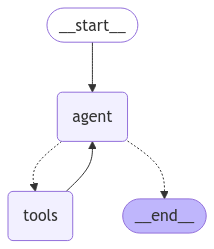

In [14]:
general_graph_builder = StateGraph(State)

general_agent_template = f"""
You are an agent tasked with searching the internet for a requested of various cities across some years. 
An example request might be \"Find the annual number of homicides for New York, New Orleans, and Los Angeles from 2019-2023 (inclusive)\".
A different request might be \"Find the populations of London, Boston, and Singapore from 2014-2016 (inclusive)\".
Each time you are requested to find a certain statistic for some cities across a range of years, strictly follow these steps:\n
1. Turn the user's request into one or more search-engine-friendly queries, and use these queries to search the internet.\n
2. Extract relevant information from the search results. If a value is not explicitly stated, do not extract it -- only extract values you are certain of.
If you do not know a value, leave that value as null.\n
3. If there is still missing information, create a refined search-engine-friendly query to search the internet with. Extract relevant information from these results.
If the information is still missing, revise your search-engine-friendly query by using synonyms and similar phrases, while preserving the semantics of the original request.\n
4. Repeat step 3 until there is no missing information. Do not proceed until all values have been found.\n
5. Once all values have been found, write the values to a csv. There should never be any null, None, or NaN values in the data that you write to the csv.
You must continue to search for information until all values have been found. You should strive for data reported at the end of the year when possible,
but in the absence of that it is sufficient to find any data point from that year.\n
The data provided to write_csv must follow the GeneralCityGroup schema. It must be a string.
The GeneralCityGroup schema is as follows:\n {general_city_group_schema.replace('{', '{{').replace('}', '}}')}\n\n
The GeneralCity schema is as follows:\n {general_city_schema.replace('{', '{{').replace('}', '}}')}
"""

general_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", general_agent_template),
    ("human", "{user_input}")
])

general_tools = [search_web, write_general_csv]

general_llm = ChatOpenAI(model="gpt-4o").bind_tools(general_tools)
general_chain = general_agent_prompt | general_llm

def general_agent(state: State):
    return {"messages": general_chain.invoke(state["messages"])}
general_graph_builder.add_node("agent", general_agent)


general_tool_node = ToolNode(tools=general_tools)
general_graph_builder.add_node("tools", general_tool_node)
general_graph_builder.add_conditional_edges(
    "agent",
    tools_condition,
)
general_graph_builder.add_edge("tools", "agent") # any time a tool is used, we want to return to the agent
general_graph_builder.add_edge(START, "agent")
general_graph = general_graph_builder.compile()

display(Image(general_graph.get_graph().draw_mermaid_png()))

In [15]:
see_output("Determine the annual homicide counts from 2019-2023 (inclusive) for New York City, New Orleans, and Los Angeles", general_graph)

{'agent': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ee9ayQUvjpLUlb4dtShyPWRB', 'function': {'arguments': '{"query": "New York City annual homicide counts 2019-2023"}', 'name': 'search_web'}, 'type': 'function'}, {'id': 'call_Ub9pSSfNRVkSxvol0NnjrGFa', 'function': {'arguments': '{"query": "New Orleans annual homicide counts 2019-2023"}', 'name': 'search_web'}, 'type': 'function'}, {'id': 'call_bufSKONOfGOLtNTrWWWJGMBh', 'function': {'arguments': '{"query": "Los Angeles annual homicide counts 2019-2023"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 1163, 'total_tokens': 1252, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1024}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87',

In [16]:
see_output("Determine the populations of New York City, Los Angeles, and New Orleans from 2019-2023 (inclusive) and write the results to a csv file.", general_graph)

{'agent': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5PAL9y5LkwYLuJdDgMNMPkaD', 'function': {'arguments': '{"query": "New York City population 2019-2023"}', 'name': 'search_web'}, 'type': 'function'}, {'id': 'call_zNiTnzDOGbHiGWc9o7NXSmc2', 'function': {'arguments': '{"query": "Los Angeles population 2019-2023"}', 'name': 'search_web'}, 'type': 'function'}, {'id': 'call_K3j0kV1zeXamlygJXT88UsfP', 'function': {'arguments': '{"query": "New Orleans population 2019-2023"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 1171, 'total_tokens': 1255, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1024}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'log